In [454]:
import numpy as np
import torch

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.fftpack import dct, idct

In [677]:
def zca_whiten(x):

    _, S, Vh = np.linalg.svd(x, full_matrices=True)
    
    Z = Vh.T @ np.diag(1.0 / (S + 1e-8))

    x = x @ Z

    return x, Z

def generate_data(dim=256, n_samples=None, zca=True, snr=None, f_offset=0, f_override=None, phase=0):

    if n_samples is None:
        n_samples = dim
    
    if f_override is None:
        f = np.arange(dim) + f_offset
    else:
        f = f_override

    x = 2 * np.cos(np.pi * f[:, None] * (2 * np.arange(dim) + 1)[None, :] / (2 * dim) + phase)
    
    if snr is not None:
        noise_amp = np.power(10.0, -snr/20.)
        
        x = x + noise_amp * np.random.randn(*x.shape)

    if zca:
        x0 = x.copy()
        x, Z = zca_whiten(x)
    else:
        x0 = x
        Z = None

    return x0, x, f/dim, Z


def generate_data_dct(dim=256, n_samples=None, zca=True, snr=None, dctarg=None):

    if n_samples is None:
        n_samples = dim
    
    f = np.arange(dim) 
    
    if dctarg is None:
        dctarg = np.eye(dim, dim)

    x = dct(dctarg, type=2).T

    if zca:
        x0 = x.copy()
        x, Z = zca_whiten(x)
    else:
        x0 = x
        Z = None

    return x0, x, f/dim, Z


def generate_data2(dim=256, n_samples=None, zca=True, snr=None):

    if n_samples is None:
        n_samples = dim
    
    f = np.linspace(0, dim/2, n_samples)
    
    f2 = (1 + np.random.rand(n_samples)) * f

    x1 = np.cos(2 * np.pi * f[:, None] * np.linspace(0.0, 1.0, dim, endpoint=False)[None, :])
    x2 = np.cos(2 * np.pi * f2[:, None] * np.linspace(0.0, 1.0, dim, endpoint=False)[None, :])
    
    x = x1 + x2
    
    if snr is not None:
        noise_amp = np.power(10.0, -snr/20.)
        
        x = x + noise_amp * np.random.randn(*x.shape)

    if zca:
        x, Z = zca_whiten(x)
    else:
        Z = None

    return x, f/dim, Z

In [343]:
def relu(z):
    return np.maximum(z, 0)

In [800]:
def solve_nn(x, y, beta=0):
    
    ypnorm = np.linalg.norm(y[y > 0])
    ynnorm = np.linalg.norm(y[y < 0])
    
    xinv = np.linalg.pinv(x)
    
    if beta < ypnorm:
        u1 = xinv @ relu(y)
        w1 = np.linalg.norm(u1)
        u1 = u1 / w1
    else:
        u1 = None
        w1 = None
    
    if beta < ynnorm:
        u2 = xinv @ relu(-y)
        w2 = np.linalg.norm(u2)
        u2 = u2 / w2
        w2 = -w2
    else:
        u2 = None
        w2 = None
    
    if u1 is not None and u2 is not None:
        u = np.stack([u1, u2], axis=1)
        w = np.stack([w1, w2], axis=0)
    elif u1 is None and u2 is not None:
        u = u2[:, None]
        w = np.array([w2])
    elif u2 is None and u1 is not None:
        u = u1[:, None]
        w = np.array([w1])
    else:
        u = np.zeros(x.shape[-1], 1)
        w = np.array([0])
    
    return u, w

In [367]:
def nn(x, W1, w2):
    return relu(x @ W1) @ w2

In [568]:
sns.set_theme('paper', 'whitegrid', 'colorblind')

In [588]:
x0, x, y, _ = generate_data_dct(dim=8, zca=False, snr=None)

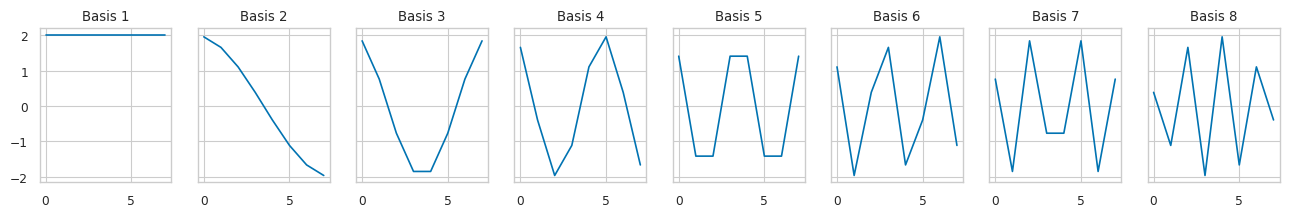

In [604]:
f, axs = plt.subplots(1, 8, figsize=(16, 2), sharey=True)

for i, ax in enumerate(axs):
    ax.plot(x[i, :])
    ax.set_title(f"Basis {i+1}")
    
plt.savefig("dct.pdf", dpi=300, bbox_inches='tight')

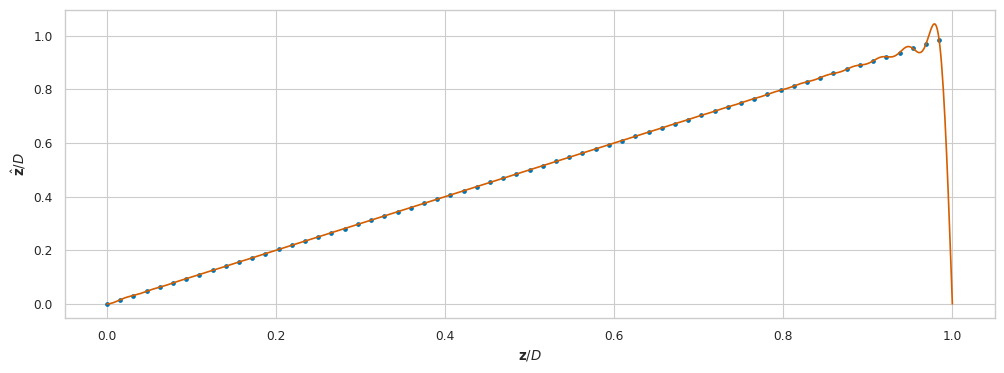

In [681]:
dim = 64

x0, x, y, _ = generate_data_dct(dim=dim, zca=False, snr=None)
x0t, xt, yt, _ = generate_data(dim=dim, zca=False, snr=None, f_override=np.linspace(0*dim, 1*dim, 1024))

W1, w2 = solve_nn(x, y)

yhat = nn(x, W1, w2)
ythat = nn(xt, W1, w2)

f, ax = plt.subplots(1, 1, figsize=(12, 4))

plt.plot(y, yhat, 'b.')
plt.plot(yt, ythat, 'r')

ax.set(xlabel=r"$\mathbf{z}/D$", ylabel=r"$\hat{\mathbf{z}}/D$")

plt.savefig("interp2.pdf", dpi=300, bbox_inches='tight')

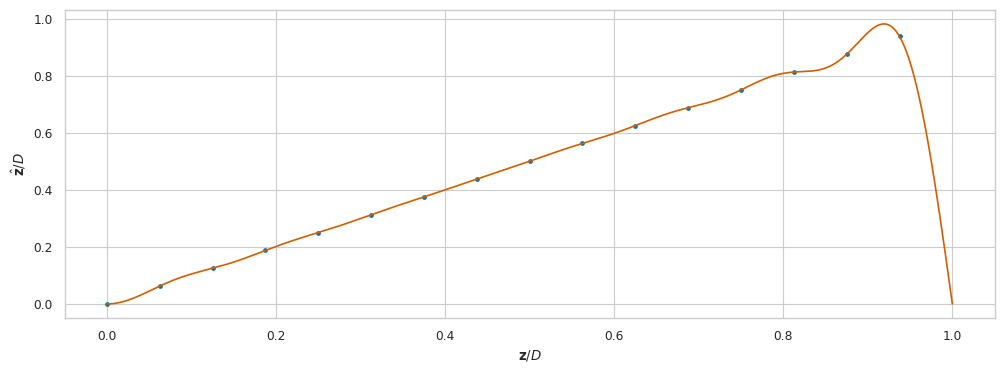

In [676]:
dim = 16

x0, x, y, _ = generate_data_dct(dim=dim, zca=False, snr=None)
x0t, xt, yt, _ = generate_data(dim=dim, zca=False, snr=None, f_override=np.linspace(0*dim, 1*dim, 1024))

W1, w2 = solve_nn(x, y)

yhat = nn(x, W1, w2)
ythat = nn(xt, W1, w2)

f, ax = plt.subplots(1, 1, figsize=(12, 4))

plt.plot(y, yhat, 'b.')
plt.plot(yt, ythat, 'r')

ax.set(xlabel=r"$\mathbf{z}/D$", ylabel=r"$\hat{\mathbf{z}}/D$")

plt.savefig("interp.pdf", dpi=300, bbox_inches='tight')

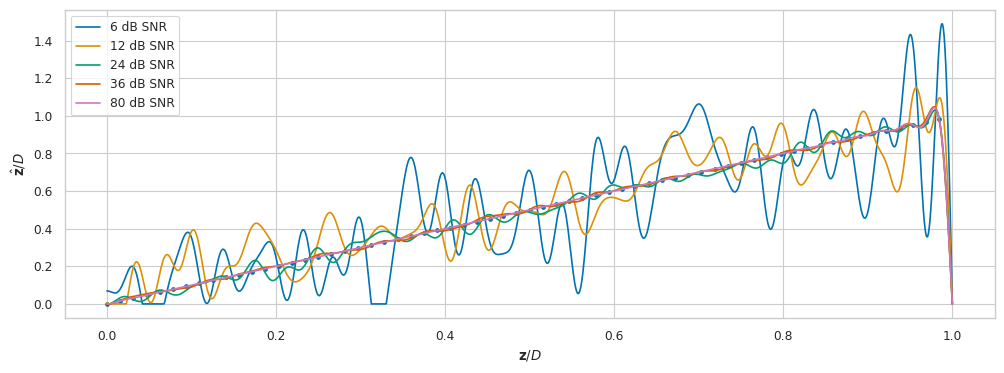

In [845]:
dim = 64

f, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y, y, 'b.')

snrs = [6, 12, 24, 36, 80]

for snr in snrs:

    x0, x, y, _ = generate_data(dim=dim, zca=False, snr=snr)
    x0t, xt, yt, _ = generate_data(dim=dim, zca=False, snr=None, f_override=np.linspace(0*dim, 1*dim, 1024))

    W1, w2 = solve_nn(x, y)

    yhat = nn(x, W1, w2)
    ythat = nn(xt, W1, w2)
    
    plt.plot(yt, ythat, label=f"{snr} dB SNR")

ax.set(xlabel=r"$\mathbf{z}/D$", ylabel=r"$\hat{\mathbf{z}}/D$")
ax.legend()

plt.savefig("snr.pdf", dpi=300, bbox_inches='tight')

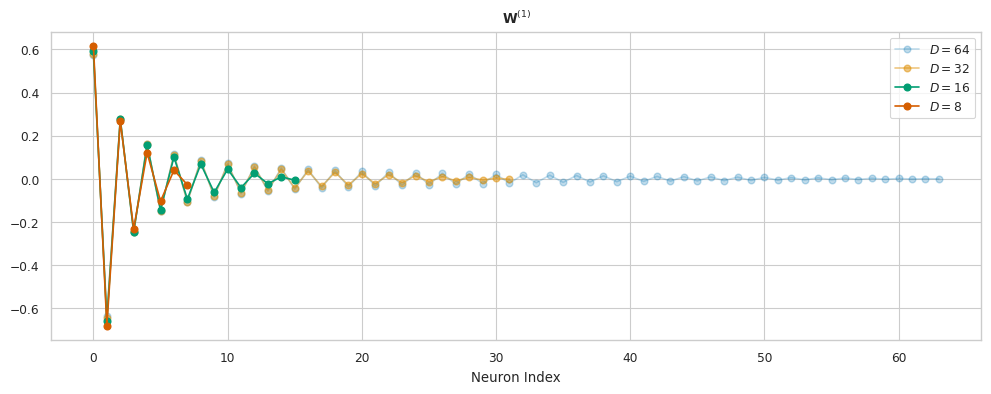

In [647]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))

W1s = []
dims = [64, 32, 16, 8]

for dim in dims:
    x0, x, y, _ = generate_data_dct(dim=dim, zca=False, snr=None)
    x0t, xt, yt, _ = generate_data(dim=dim, zca=False, snr=None, f_override=np.linspace(0, dim, 1000))
    W1, w2 = solve_nn(x, y)
    
    W1s.append(W1.flatten())

for dim, W1 in zip(dims, W1s):
    ax.plot(W1, "o-", label=f"$D={dim}$", alpha=min(1, 16/dim))
    # ax.plot(W1, "-", label=f"$D={dim}$")

    
ax.legend()

ax.set_title(r"$\mathbf{W}^{(1)}$")
ax.set_xlabel("Neuron Index")
# ax.set_xticks([0] + dims)

plt.savefig("w1.pdf", dpi=300, bbox_inches='tight')